Geospatial Analysis
- References: https://github.com/dsgt-birdclef/birdclef-eda-f22/blob/main/users/acmiyaguchi/notebooks/2022-10-23-birdcall-distribution.ipynb

In [1]:
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 58.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.2 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp38-cp38-linux_x86_64.whl size=11127981 sha256=6e67934f0c2ab0e34397fa5e79975c02fb8606c30d96589ada59cbdea564f062
  Stored in directory: /root/.cache/pip/wheels/7c/ff/6f/09e4aa53f4e67d6498ef1d33dd4ea9c8c165817b9ddcc31d28
Successfully built cartopy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cartopy.io import shapereader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, Polygon

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [4]:
df = pd.read_csv("/content/gdrive/MyDrive/BirdCLEF/train_metadata.csv")
df.head(50)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg
5,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,16:30,https://www.xeno-canto.org/207432,afrsil1/XC207432.ogg
6,afrsil1,[],['call'],21.3561,-158.0205,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/209513,afrsil1/XC209513.ogg
7,afrsil1,[],"['flight call', 'traffic']",10.1538,-0.7996,Euodice cantans,African Silverbill,Phil Gregory,Creative Commons Attribution-NonCommercial-Sha...,3.0,09:00,https://www.xeno-canto.org/234994,afrsil1/XC234994.ogg
8,afrsil1,[],['call'],14.5088,-17.0696,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:00,https://www.xeno-canto.org/317039,afrsil1/XC317039.ogg
9,afrsil1,[],['call'],14.7279,-17.4329,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,3.5,10:30,https://www.xeno-canto.org/322742,afrsil1/XC322742.ogg


From the [Kaggle data page](https://www.kaggle.com/competitions/birdclef-2022/data), here are some details about the columns of `df`:

- primary_label - a code for the bird species. You can review detailed information about the bird codes at https://ebird.org/species/amecro for the American Crow, for example.
- secondary_labels: Background species as annotated by the recordist. An empty list does not mean that no background birds are audible.
- author - the eBird user who provided the recording.
- filename: the associated audio file.
- rating: Float value between 0.0 and 5.0 as an indicator of the quality rating on Xeno-canto and the number of background species, where 5.0 is the highest and 1.0 is the lowest. 0.0 means that this recording has no user rating yet.

# Data Preparation

- The distribution maps can act as important priors for classification tasks.

In [5]:
visual_df = df.copy()
# groupby() with as_index = False returns a data frame
top_10_df = visual_df.groupby('primary_label', as_index = False).size() \
                          .nlargest(10, 'size', keep = 'all')

#top 10 bird species by population
top_10_list = list(top_10_df['primary_label'])
top_10_df

,primary_label,size
21,brnowl,500
41,comsan,500
68,houspa,500
87,mallar3,500
94,norcar,500
131,skylar,500
45,dunlin,476
53,gnwtea,463
10,bcnher,462
96,normoc,387


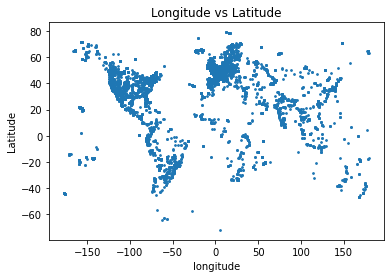

In [6]:
def plot_lonlat1(df: pd.DataFrame, **kwargs):
  """Plot longitude vs latitude."""
  x=df['longitude']
  y=df['latitude']
  plt.scatter(x,y,s=3,**kwargs)
  plt.title("Longitude vs Latitude")
  plt.xlabel("longitude")
  plt.ylabel("Latitude")
  plt.show()

def plot_lonlat(df: pd.DataFrame, bird: str, **kwargs):
  """Plot longitude vs latitude."""
  x=df['longitude']
  y=df['latitude']
  plt.scatter(x,y,s=3,**kwargs)
  plt.title("{} longitude vs latitude".format(bird))
  plt.xlabel("longitude")
  plt.ylabel("Latitude")
  plt.show()

plot_lonlat1(df)

Goal: Plot the top 10 species
- The first 5 bird species each have 500 habitats being the most populated
- Most of them are located at the Northern Hemisphere above 20th parallel north
-  Among the top 10 speicies, 8 of them seem to gather at one place or around, with only some individual groups that are scattered everywhere

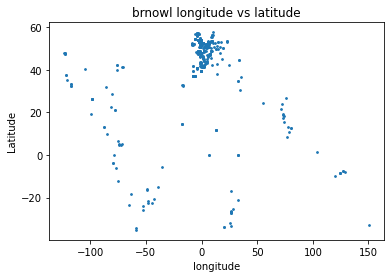

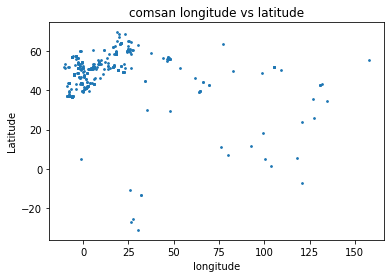

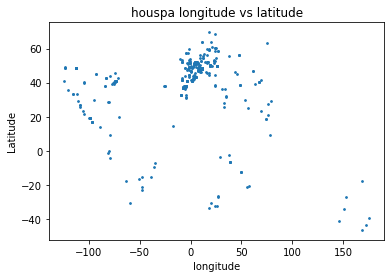

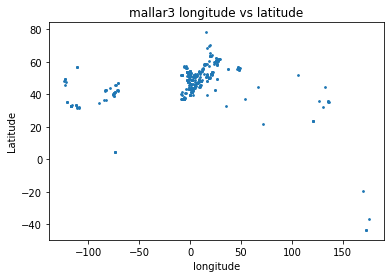

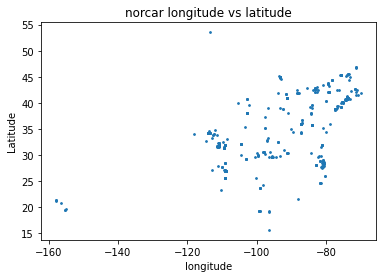

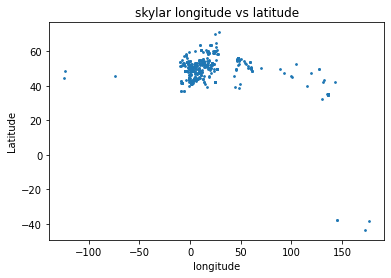

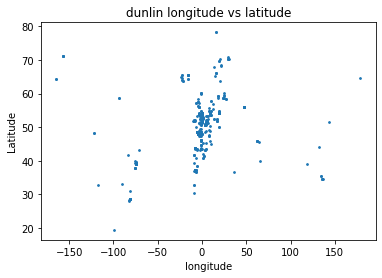

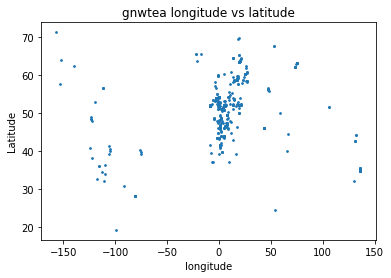

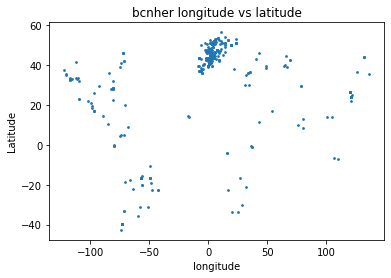

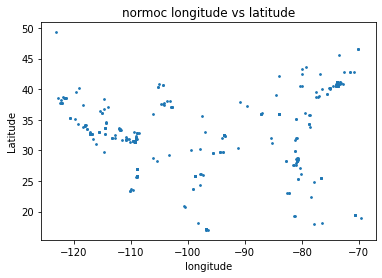

In [7]:
for bird in top_10_list:
  df1 = visual_df[visual_df['primary_label'] == bird]
  plot_lonlat(df1, bird)
  print('\n')

In [8]:
df.loc[(df['secondary_labels'].str.len() !=2),:].head() #not a string '' in the column of the secondary label 
#find the potential neighbor bird species, exclude rows without any label

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
18,akekee,"['apapan', 'warwhe1']","['call', 'male']",22.1467,-159.6134,Loxops caeruleirostris,Akekee,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.5,09:00,https://www.xeno-canto.org/210201,akekee/XC210201.ogg
19,akekee,['apapan'],"['call', 'male', 'song']",22.0815,-159.5550,Loxops caeruleirostris,Akekee,Patrick Blake,Creative Commons Attribution-NonCommercial-Sha...,3.5,14:00,https://www.xeno-canto.org/219961,akekee/XC219961.ogg
20,akekee,['iiwi'],['call'],22.1467,-159.6134,Loxops caeruleirostris,Akekee,Daniel Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,12:30,https://www.xeno-canto.org/27306,akekee/XC27306.ogg
22,akepa1,"['akiapo', 'apapan', 'hawama', 'hawcre', 'iiwi']",['call'],19.6292,-155.3597,Loxops coccineus,Hawaii Akepa,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,2.5,14:14,https://www.xeno-canto.org/122473,akepa1/XC122473.ogg


/usr/local/lib/python3.8/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


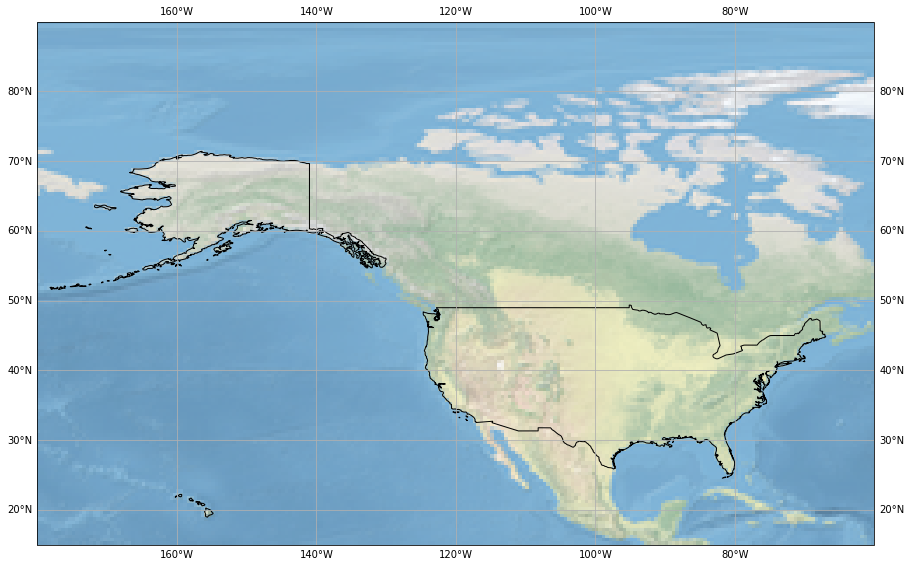

In [9]:
# Use cartopy and shapely tools to plot birdcall data in United States
subset_df = df[["primary_label", "latitude", "longitude"]].dropna()

reader = shapereader.Reader(
    shapereader.natural_earth(
        resolution="50m", category="cultural", name="admin_0_countries"
    )
)
US = [
    s
    for s in reader.records()
    if s.attributes["ADMIN"] == "United States of America"
][0]

fig = plt.figure(figsize=(15, 11))
projection = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
ax.stock_img()
# xlim and ylim for United States, manually found
ax.set_xlim(-180, -60)
ax.set_ylim(15,90)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.add_feature(
    cfeature.ShapelyFeature([US.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)
plt.show()

In [10]:
points_in_US = subset_df.apply(
    lambda x: US.geometry.contains(Point(x.longitude, x.latitude)), axis=1
)
US_df = subset_df[points_in_US]
print("Top 10 bird species in US: ")
print(US_df.primary_label.value_counts()[:10].to_dict())

Top 10 bird species in US: 
{'norcar': 391, 'wesmea': 282, 'normoc': 276, 'houfin': 177, 'moudov': 109, 'gamqua': 103, 'pibgre': 98, 'towsol': 94, 'calqua': 87, 'sora': 86}


Plot with bird speicies data points on the map within the US boundary

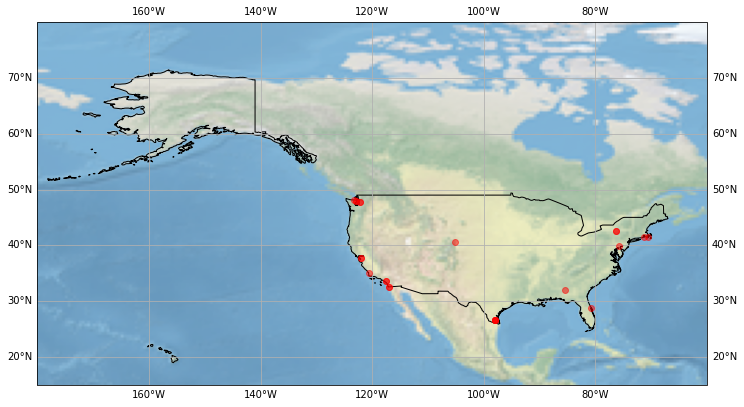

In [11]:
fig = plt.figure(figsize=(12, 7))
projection = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
ax.stock_img()
ax.set_xlim(-180, -60)
ax.set_ylim(15,80)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.add_feature(
    cfeature.ShapelyFeature([US.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)

# add points from the US subset
# show the map for top 10 bird specieis
for bird in top_10_list:
  US_df1 = US_df[US_df['primary_label'] == bird]
  for i, row in US_df1.iterrows():
      ax.plot(
          row.longitude,
          row.latitude,
          "o",
          color="r",
          transform=ccrs.PlateCarree(),
          alpha=0.5,
      )

  plt.show()

Discretize Geographical Data

In [12]:
def generate_grid(df, shape, map_dims, grid_dims):
    xmin, xmax, ymin, ymax = map_dims
    length, width = grid_dims

    # generate a grid of polygons that intersect with the provided shape
    polygons = {}
    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + length, length))
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygon = Polygon(
                [(x, y), (x + width, y), (x + width, y + length), (x, y + length)]
            )
            if shape.geometry.intersects(polygon):
                polygons[f"{x}_{y}"] = polygon

    # now generate a new dataframe where points are contained within the shape
    points = df.apply(
        lambda x: shape.geometry.contains(Point(x.longitude, x.latitude)), axis=1
    )
    res_df = subset_df[points].copy()

    # add the appropriate grid for each point
    res_df["grid"] = res_df.apply(
        lambda x: [
            k for k, p in polygons.items() if p.contains(Point(x.longitude, x.latitude))
        ][0],
        axis=1,
    )
    return res_df, polygons


US_df, polygons = generate_grid(subset_df, US, [-180, -60, 15, 80], [0.5, 0.5])
print(f"{len(polygons)} grid items")
US_df.head()

4973 grid items


,primary_label,latitude,longitude,grid
1,afrsil1,19.8801,-155.7254,-156.0_19.5
6,afrsil1,21.3561,-158.0205,-158.5_21.0
16,akekee,22.1467,-159.6134,-160.0_22.0
17,akekee,22.1467,-159.6134,-160.0_22.0
18,akekee,22.1467,-159.6134,-160.0_22.0


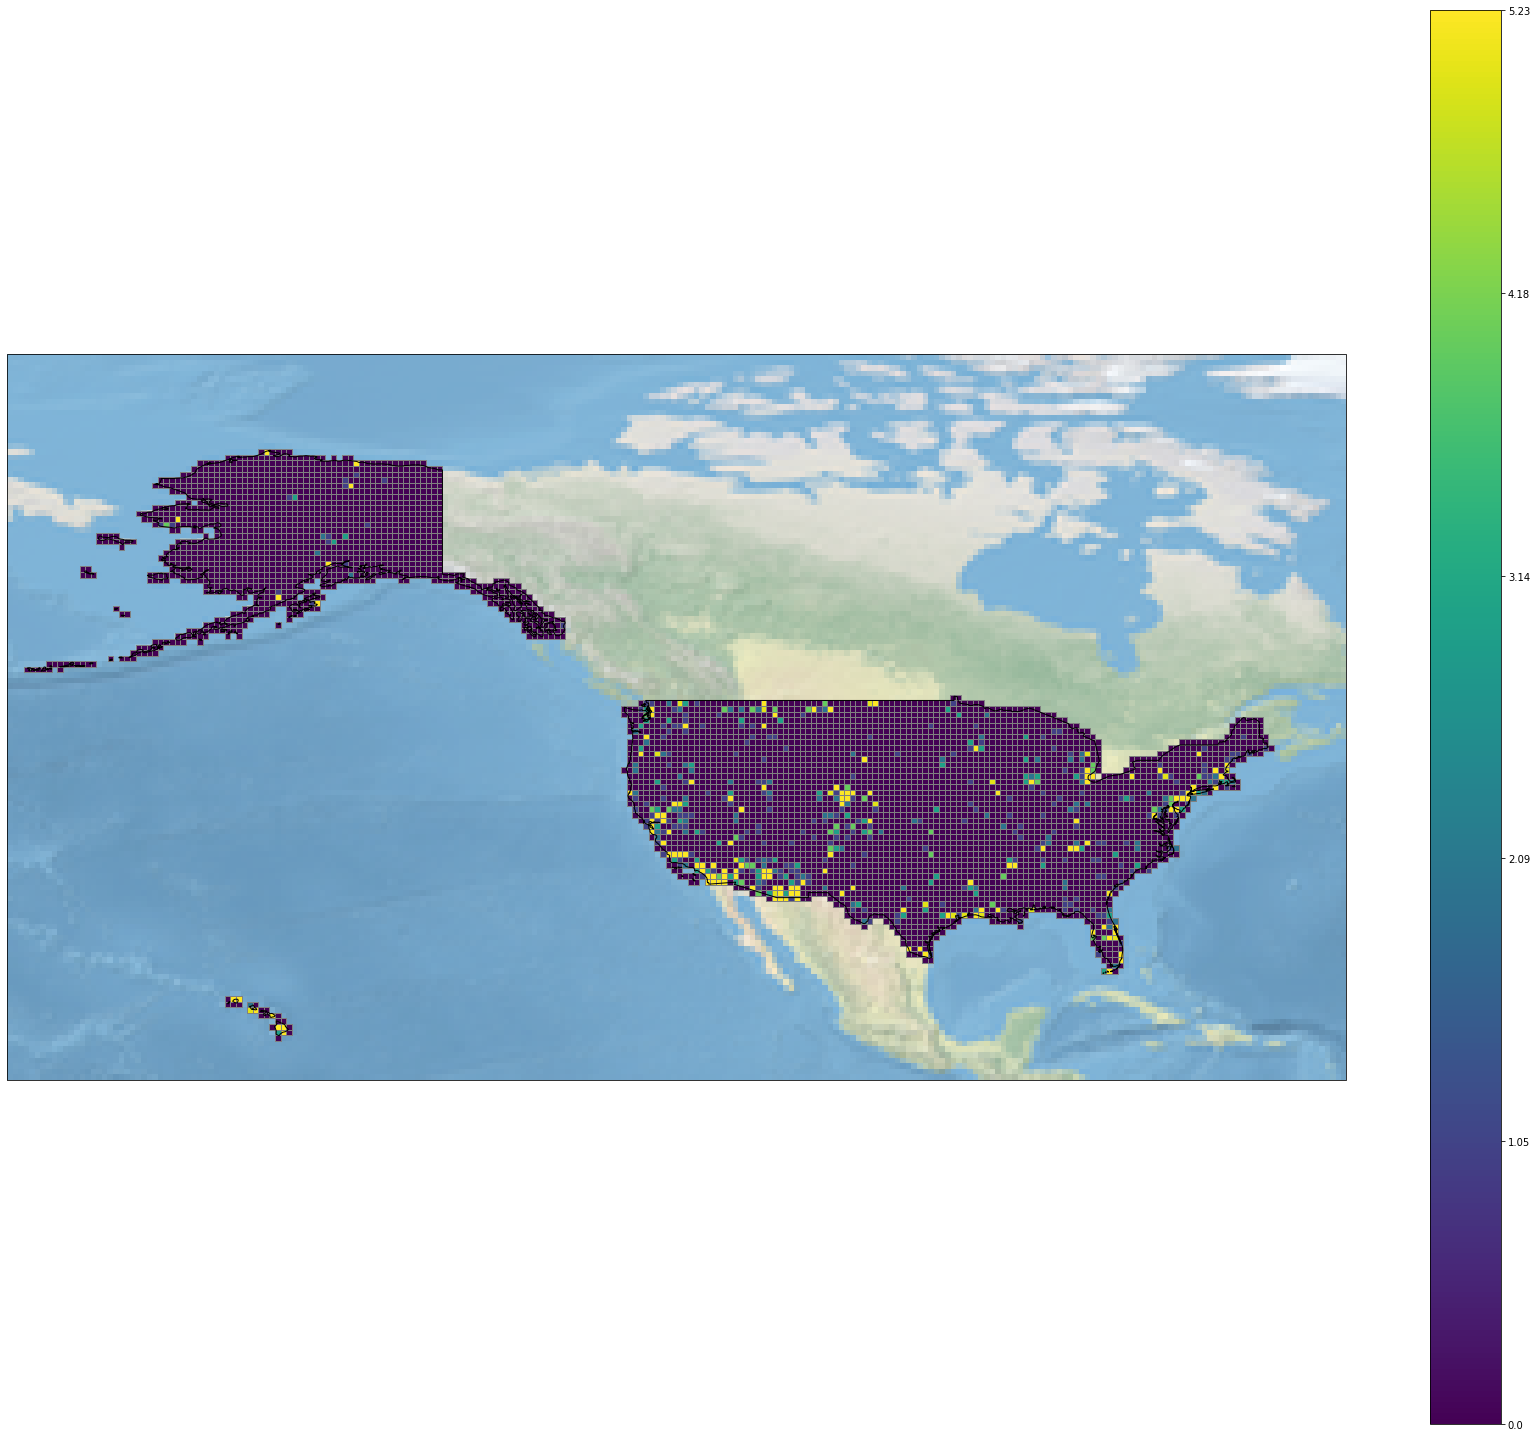

In [13]:
fig = plt.figure(figsize=(30, 26))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.stock_img()
ax.set_xlim(-180,-60)
ax.set_ylim(15,80)

# log scale the counts
size = np.log(US_df.groupby("grid").size())
expected = size.mean()
vmin = size.min()
vmax = size.max()
color_getter = lambda x: plt.get_cmap("viridis")(np.interp(x, [vmin, vmax], [0, 1]))

for key, polygon in polygons.items():
    ax.add_feature(
        cfeature.ShapelyFeature([polygon], projection),
        edgecolor="gray",
        facecolor=color_getter(US_df[US_df.grid == key].shape[0]),
    )

ax.add_feature(
    cfeature.ShapelyFeature([US.geometry], projection),
    edgecolor="k",
    facecolor=(1, 1, 1, 0),
)

cbar = fig.colorbar(plt.matplotlib.cm.ScalarMappable(norm=None, cmap="viridis"), ax=ax)
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.set_ticklabels(
    [f"{round(np.interp(x, [0, 1], [vmin, vmax]), 2)}" for x in cbar.get_ticks()]
)

plt.show()

Kernel Density Estimate of Species Distributions

- Bandwidth determines how smooth the resulting curve is.
- Haversine distance metrics measures the angular distance between points on a sphere and can be used with kernel density estimator.

Visualize lattitude vs density and longittude vs density respectively
- adjust the bw_adjust parameter to make the curve more smoothing 
- KDE Plot, also called Kernel Density Estimate, helps visualizing the probability density of a continuous variable if performing kernel density estimation for lattitude / longitude in this case. It shows the probability density at different values in a continuous value. 

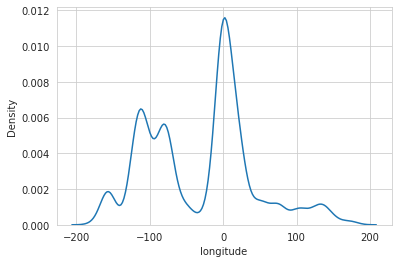

In [14]:
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(x=df.longitude,bw_adjust=0.9)

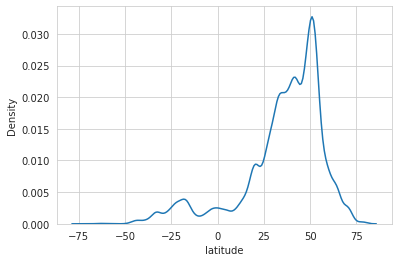

In [15]:
sns.kdeplot(x=df.latitude, bw_adjust=0.7)

In [16]:
#kernel density estimation with 2-d array shown as below
import numpy as np
from sklearn.neighbors import KernelDensity
# convert to np array
np_kd = df[['longitude','latitude']].to_numpy()

#The bigger the bandwidth, the smoother the distribution is
kde = KernelDensity(metric="haversine", kernel='gaussian', bandwidth=0.05, algorithm="ball_tree")
kde = kde.fit(np_kd)
kde.score_samples(np_kd)

array([ 0.03032035, -1.63575889, -3.69355728, ..., -2.85937112,
       -2.29962848, -2.29962848])

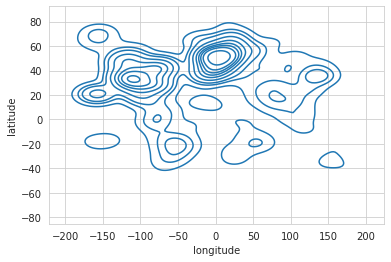

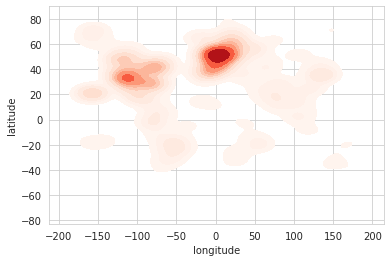

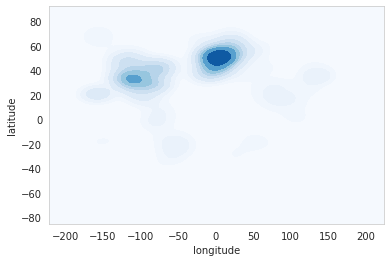

In [17]:
#contour plot using seaborn
import seaborn as sns
# set seaborn style
sns.set_style('whitegrid')

# Basic 2D density plot
sns.kdeplot(x=df.longitude, y=df.latitude)
plt.show()
# with shade
sns.kdeplot(x=df.longitude, y=df.latitude, cmap="Reds", shade=True, bw_adjust=.8)
plt.show()
#With thresh parameter
sns.kdeplot(x=df.longitude, y=df.latitude, cmap="Blues", shade=True, thresh=0)
plt.show()


Visualizing histogram with Matplotlib and Pandas

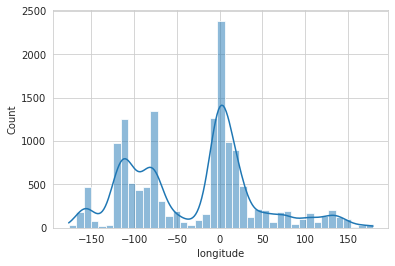

In [18]:
sns.histplot(x = df.longitude, kde=True)

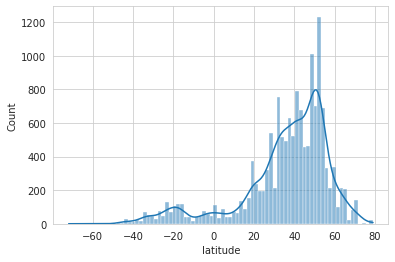

In [19]:
sns.histplot(x = df.latitude, kde=True)

- Create a density map to show which bird species are located. The point data can be smoothed into a heat map
- sns has a plot function analogous to a Heat Map

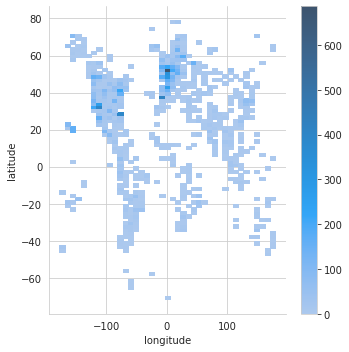

In [20]:
sns.displot(df, x= df.longitude, y=df.latitude,cbar=True)


The contour approach of the bivariate KDE plot lends itself better to evaluating overlap.

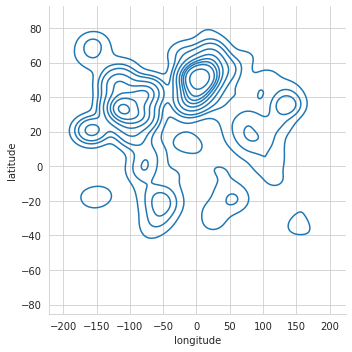

In [21]:
sns.displot(df, x= df.longitude, y=df.latitude, kind="kde")

In [22]:
top_10_list

['brnowl',
 'comsan',
 'houspa',
 'mallar3',
 'norcar',
 'skylar',
 'dunlin',
 'gnwtea',
 'bcnher',
 'normoc']